In [1]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import fly_analysis as fa
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import seaborn as sns

In [32]:
def plot_matrix(df, group):
    # 2. Calculate transition probabilities
    transition_matrix = pd.crosstab(df['before_direction'], df['after_direction'], normalize='index')

    # 3. Create visualization
    plt.figure(figsize=(12, 10))
    sns.heatmap(transition_matrix, annot=True, cmap='YlGnBu', fmt='.2f', cbar_kws={'label': 'Probability'})
    plt.title('Transition Probabilities between Saccade Directions (Including No Turn)')
    plt.xlabel('After Direction')
    plt.ylabel('Before Direction')
    plt.tight_layout()
    plt.title(group)
    plt.show()

    # 4. Print the transition matrix
    print("Transition Probability Matrix:")
    print(transition_matrix)

    # 5. Calculate overall probability of maintaining the same direction or no turn
    same_direction_prob = np.diagonal(transition_matrix).mean()
    print(f"\nOverall probability of maintaining the same direction or no turn: {same_direction_prob:.2f}")

    # 6. Calculate probabilities for specific transitions
    prob_turn_to_no_turn = transition_matrix.loc[['left', 'right'], 'no turn'].mean()
    prob_no_turn_to_turn = transition_matrix.loc['no turn', ['left', 'right']].sum()

    print(f"\nProbability of transitioning from a turn to no turn: {prob_turn_to_no_turn:.2f}")
    print(f"Probability of transitioning from no turn to a turn: {prob_no_turn_to_turn:.2f}")

def smooth_columns(df, columns=["x", "y", "z", "xvel", "yvel", "zvel"]):
    """
    smooth selected columns in dataframe using savgol_filter
    """
    for col in columns:
        if col in df.columns:
            arr = df[col].to_numpy()
            df[f"original_{col}"] = arr.copy()
            df[col] = savgol_filter(arr, 21, 3)
    return df

def calculate_angular_velocity(df):
    theta = np.arctan2(df["yvel"].to_numpy(), df["xvel"].to_numpy())
    theta_unwrap = np.unwrap(theta)
    angular_velocity = np.gradient(theta_unwrap, 0.01)
    return np.rad2deg(
        angular_velocity
    )  # Convert radians to degrees for angular_velocity


def detect_saccades(angular_velocity, threshold=500):  # Adjust threshold as needed
    peaks, _ = find_peaks(np.abs(angular_velocity), height=threshold)
    return peaks


def get_turn_direction(value):
    if value > 0:
        return "right"
    elif value < 0:
        return "left"
    else:
        return "no turn"

def get_amplitude(xvel, yvel):
    heading_before = np.arctan2(yvel, xvel)

def analyze_turns(df, opto, pre_stim_window=100, post_stim_window=30):
    results = []
    i_plots = 0
    for _, row in opto.iterrows():
        obj_id = int(row["obj_id"])
        frame = int(row["frame"])
        grp = df[df.obj_id == obj_id].copy()

        try:
            opto_idx = np.where(grp.frame == frame)[0][0]
        except IndexError:
            #print("Can't find opto frame")
            continue

        idx_before = opto_idx - pre_stim_window
        idx_after = opto_idx + post_stim_window

        if idx_before < 0 or idx_after > len(grp):
            #print("Indices out of bounds")
            continue
        
        grp = smooth_columns(grp)
        angular_velocity = calculate_angular_velocity(grp)
        is_saccade = detect_saccades(angular_velocity)

        # check for any saccades within the window before and during the stimulus
        saccades_before = [
            sac for sac in is_saccade if sac >= idx_before and sac <= opto_idx
        ]
        saccades_after = [
            sac for sac in is_saccade if sac > opto_idx and sac <= idx_after
        ]

        # get turn directions for saccades
        if len(saccades_before) > 0:
            before_direction = get_turn_direction(angular_velocity[saccades_before[-1]])
            before_idx = saccades_before[-1]
        else:
            before_direction = "no turn"
            before_idx = np.nan

        if len(saccades_after) > 0:
            after_direction = get_turn_direction(angular_velocity[saccades_after[0]])
            after_idx = saccades_after[0]
        else:
            after_direction = "no turn"
            after_idx = np.nan

        if after_idx is not np.nan and before_idx is not np.nan:
            time_between_saccades = (after_idx - saccades_before[-1])*0.01
        else:
            time_between_saccades = np.nan

        x = grp.x.to_numpy()[idx_before:idx_after]
        y = grp.y.to_numpy()[idx_before:idx_after]
        xvel = grp.xvel.to_numpy()
        yvel = grp.yvel.to_numpy()
        linear_velocity = np.sqrt(xvel**2 + yvel**2)[idx_before:idx_after]
        angvel = angular_velocity[idx_before:idx_after]
        is_saccade_in_range = detect_saccades(angvel)

        # fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(15, 3))
        # axs[0].plot(x, y)
        # axs[0].scatter(x[0], y[0], color='black', marker='x')
        # axs[0].scatter(x[opto_idx-idx_before], y[opto_idx-idx_before], color='red')
        
        # axs[1].plot(angvel)
        # axs[1].scatter(100, angvel[100], color='red')
        # axs[1].scatter(is_saccade_in_range, angvel[is_saccade_in_range], color="green", marker="x")
        # plt.show()

        results.append(
            {
                "obj_id": obj_id,
                "frame": frame,
                "before_index": before_idx,
                "before_direction": before_direction,
                "after_index": after_idx,
                "after_direction": after_direction,
                "time_between_saccades": time_between_saccades,
            }
        )

        # i_plots+=1
        # if i_plots == 3:
        #     break

    return pd.DataFrame(results)

In [3]:
root_folder = "/home/buchsbaum/mnt/md0/Experiments/"
j21_files = ["20230906_155507.braidz"]
j73_files = [
    "20240910_140319.braidz",
    "20240912_140309.braidz",
    "20240914_140037.braidz",
]
j74_files = [
    "20240911_151201.braidz",
    "20240913_141235.braidz",
    "20240915_140001.braidz",
]
j21 = fa.braidz.read_multiple_braidz(j21_files, root_folder)
j74 = fa.braidz.read_multiple_braidz(j74_files, root_folder)
j73 = fa.braidz.read_multiple_braidz(j73_files, root_folder)

Reading /home/buchsbaum/mnt/md0/Experiments/20230906_155507.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Experiments/20240911_151201.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Experiments/20240913_141235.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Experiments/20240915_140001.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Experiments/20240910_140319.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Experiments/20240912_140309.braidz using pyarrow
Reading /home/buchsbaum/mnt/md0/Experiments/20240914_140037.braidz using pyarrow


In [33]:
j21["results"] = analyze_turns(j21["df"], j21["opto"])
j73["results"] = analyze_turns(j73["df"], j73["opto"])
j74["results"] = analyze_turns(j74["df"], j74["opto"])

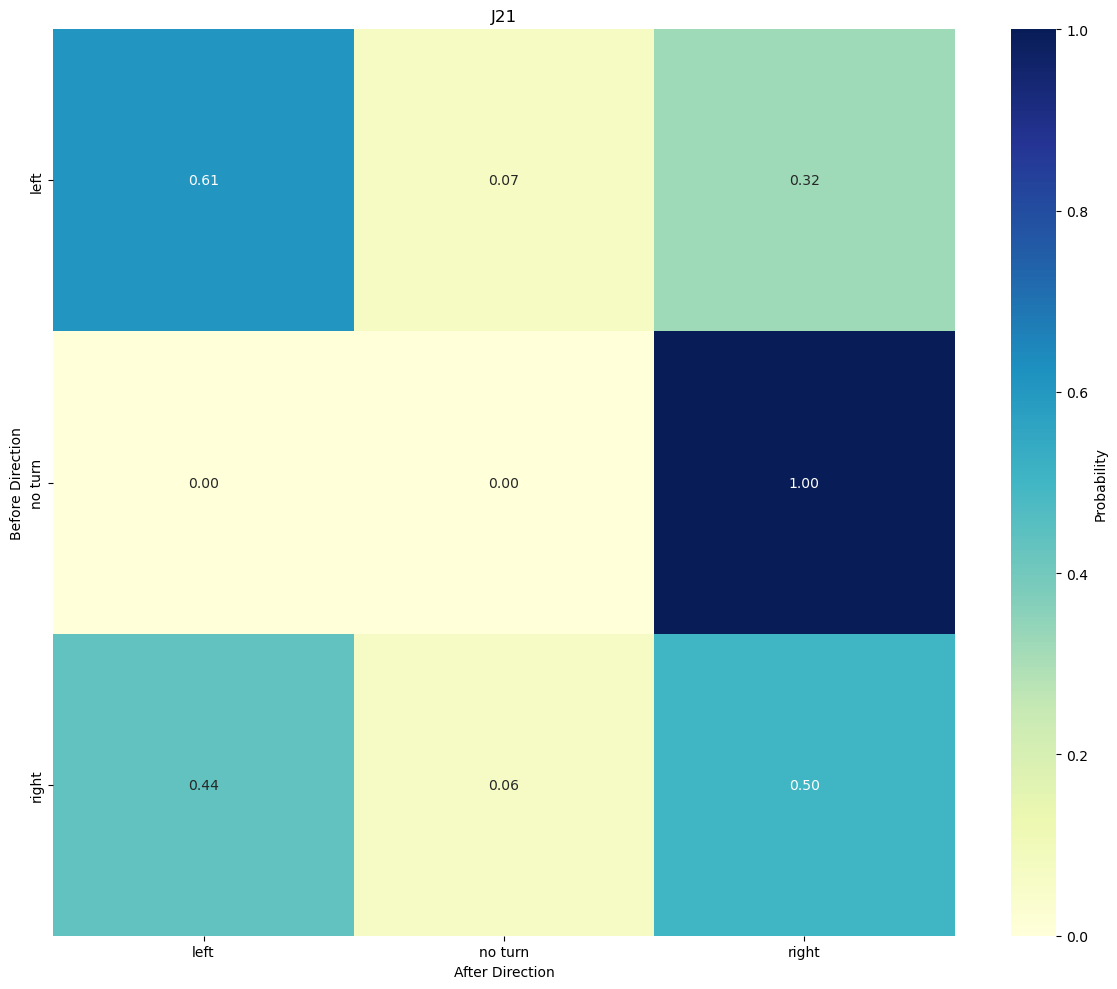

Transition Probability Matrix:
after_direction       left   no turn     right
before_direction                              
left              0.605505  0.073394  0.321101
no turn           0.000000  0.000000  1.000000
right             0.435897  0.064103  0.500000

Overall probability of maintaining the same direction or no turn: 0.37

Probability of transitioning from a turn to no turn: 0.07
Probability of transitioning from no turn to a turn: 1.00


In [34]:
plot_matrix(j21["results"], "J21")

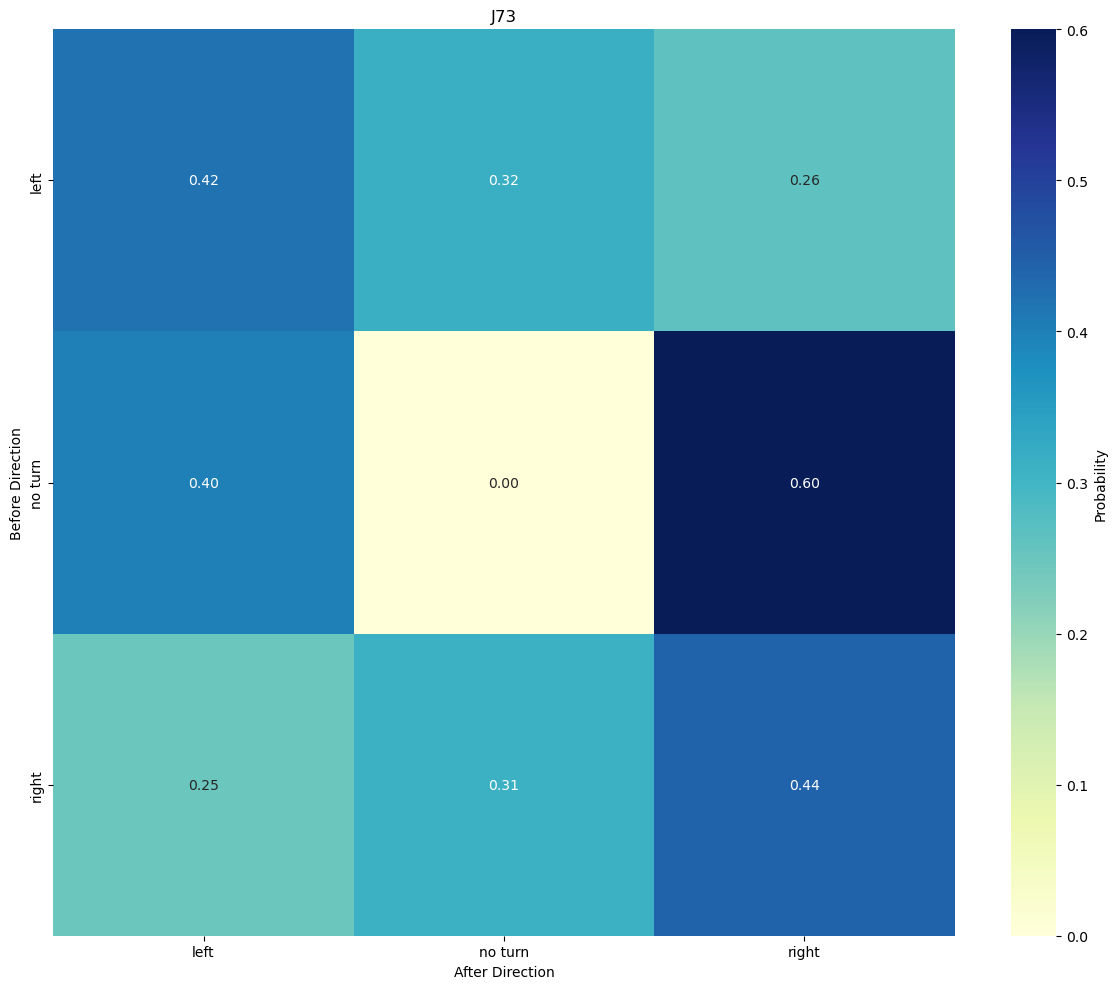

Transition Probability Matrix:
after_direction       left   no turn     right
before_direction                              
left              0.419913  0.316017  0.264069
no turn           0.400000  0.000000  0.600000
right             0.249057  0.309434  0.441509

Overall probability of maintaining the same direction or no turn: 0.29

Probability of transitioning from a turn to no turn: 0.31
Probability of transitioning from no turn to a turn: 1.00


In [35]:
plot_matrix(j73["results"], "J73")

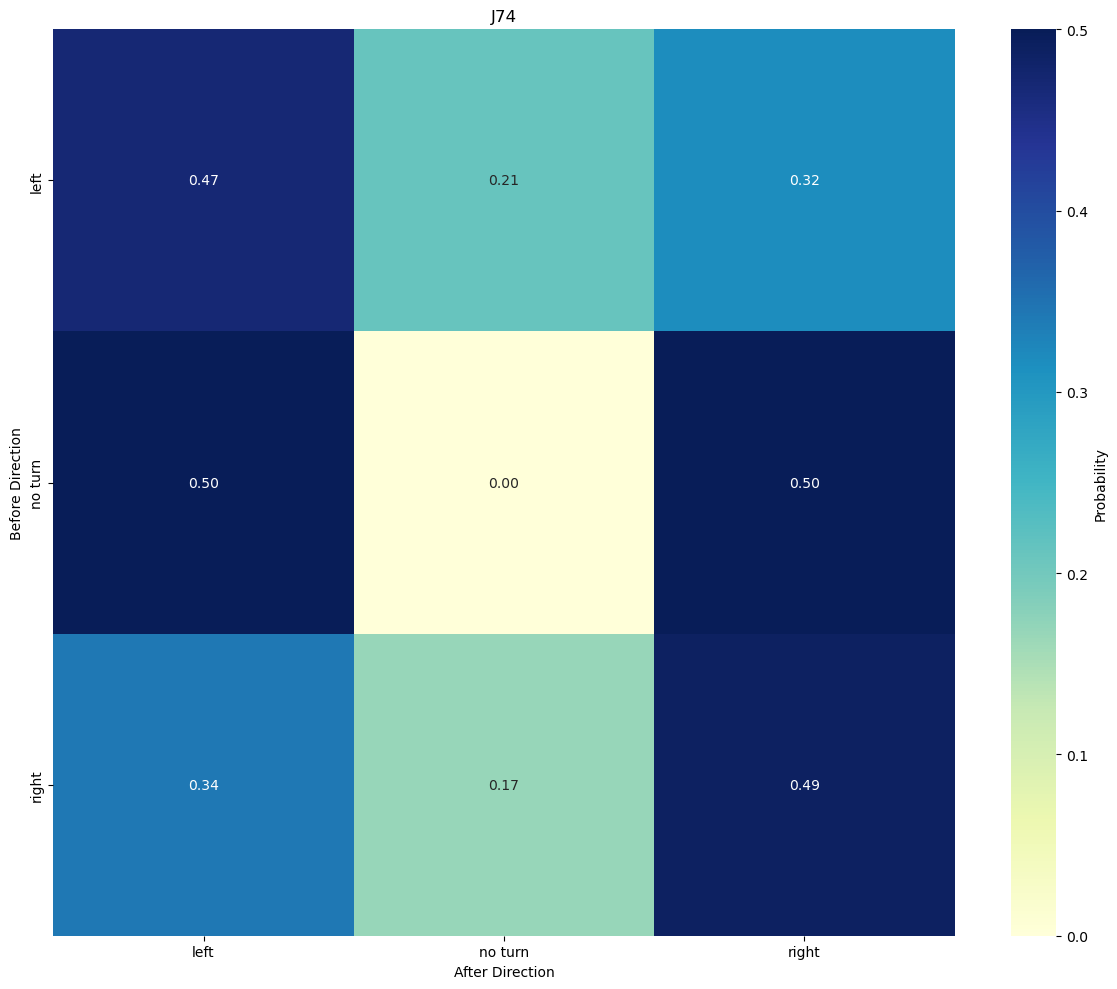

Transition Probability Matrix:
after_direction       left   no turn     right
before_direction                              
left              0.470588  0.211765  0.317647
no turn           0.500000  0.000000  0.500000
right             0.342282  0.167785  0.489933

Overall probability of maintaining the same direction or no turn: 0.32

Probability of transitioning from a turn to no turn: 0.19
Probability of transitioning from no turn to a turn: 1.00


In [36]:
plot_matrix(j74["results"], "J74")